In [57]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy import stats
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

**Dataset description:**
синтетический датасет, используемый для тестовых заданий аналитикам.
В нем содержатся данные об установках и всех платежах, совершаемых пользователями во всех приложениях и на всех платформах. Таблица содержит следующие колонки, необходимые для решения задачи:
* Game_ID - название приложения. Примеры: “Hidden City”, “Jewels of Rome”, “Mahjong Journey”.
* Platform - платформа, на которой играет пользователь. Примеры: “Android”, “Facebook”, “iOS”.
* Device_ID - уникальный идентификатор устройства пользователя. Пример: “14321DLVRF5636”.
* Install_DateTime - дата и время установки (первого запуска) приложения. Пример: “2019-12-01 15:54:12”.
* Payment_DayTime - дата и время совершения платежа. Пример: “2019-12-01 15:54:12”.
* Payment_Amount - сумма совершенного платежа в USD. Пример: “49.99”.

За отсутствием данных об activity cделаем допущение, что в таблице находятся данные о платежах к 4му дню игры, то есть у каждого last activity day = install day + 4, лайфтайм когорты 4 дня

**Что планирую сделать**

* Добавить в датасет Total Payments для каждого пользователя
* Проверить распределение Total Payments на нормальность
* Проверить гипотезу о том, что мат ожидание Total Payments одинаковое во всех играх
* Проанализировать влияние платформы на Total Payments (можно в одной игре)
* Проверить на корреляцию Total Payments и временной промежуток между инсталлом и датой последнего платежа
* Проверить, есть ли корреляция между размером первой покупки и временем до нее с момента инсталла

## Read and prepare data

In [58]:
DATASET_PATH = 'D:/GeekBrains/math_stats/final/dataset_202010211425.csv'

In [59]:
df = pd.read_csv(DATASET_PATH)
df.head(5)

,Game_ID,Platform,Device_ID,Install_DateTime,Payment_DayTime,Payment_Amount
0,Hidden City,iOS,10084FTRLK4558,2019-09-15 13:55:00,2019-09-16 04:31:00,9.99
1,Hidden City,iOS,10084FTRLK4558,2019-09-15 13:55:00,2019-09-16 22:16:00,9.99
2,Hidden City,iOS,10924YVEGF1782,2019-09-15 11:43:00,2019-09-17 06:33:00,9.99
3,Hidden City,iOS,10924YVEGF1782,2019-09-15 11:43:00,2019-09-17 13:21:00,99.99
4,Hidden City,iOS,10924YVEGF1782,2019-09-15 11:43:00,2019-09-17 16:21:00,1.99


In [60]:
df.drop_duplicates(['Game_ID', 'Platform', 'Device_ID']).shape

(31317, 6)

In [61]:
total_payments = pd.DataFrame(df.groupby(['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime']).agg({'Payment_Amount': 'sum'}))
total_payments.index = total_payments.index.set_names(['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime'])
total_payments.reset_index(inplace = True)
total_payments = total_payments.rename({'Payment_Amount': 'Total_Payments'}, axis=1)
total_payments.head(5)

,Game_ID,Platform,Device_ID,Install_DateTime,Total_Payments
0,Hidden City,Android,10035NEIPI8402,2019-11-10 20:19:00,150.97
1,Hidden City,Android,10042SDNBF7065,2019-10-18 01:12:00,70.96
2,Hidden City,Android,10061PSNAJ3947,2019-09-24 02:22:00,119.97
3,Hidden City,Android,10127ZEHMN6457,2019-10-12 11:09:00,89.95
4,Hidden City,Android,10156IEACL3321,2019-10-21 04:54:00,111.97


In [62]:
dataset = pd.merge(df, total_payments, on = ['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime'])
dataset.head(5)

,Game_ID,Platform,Device_ID,Install_DateTime,Payment_DayTime,Payment_Amount,Total_Payments
0,Hidden City,iOS,10084FTRLK4558,2019-09-15 13:55:00,2019-09-16 04:31:00,9.99,19.98
1,Hidden City,iOS,10084FTRLK4558,2019-09-15 13:55:00,2019-09-16 22:16:00,9.99,19.98
2,Hidden City,iOS,10924YVEGF1782,2019-09-15 11:43:00,2019-09-17 06:33:00,9.99,171.95
3,Hidden City,iOS,10924YVEGF1782,2019-09-15 11:43:00,2019-09-17 13:21:00,99.99,171.95
4,Hidden City,iOS,10924YVEGF1782,2019-09-15 11:43:00,2019-09-17 16:21:00,1.99,171.95


In [63]:
last_payments = pd.DataFrame(df.groupby(['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime']).agg({'Payment_DayTime': 'max'}))
last_payments.index = last_payments.index.set_names(['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime'])
last_payments.reset_index(inplace = True)

last_payments.head(5)

,Game_ID,Platform,Device_ID,Install_DateTime,Payment_DayTime
0,Hidden City,Android,10035NEIPI8402,2019-11-10 20:19:00,2019-11-13 21:33:00
1,Hidden City,Android,10042SDNBF7065,2019-10-18 01:12:00,2019-10-21 09:06:00
2,Hidden City,Android,10061PSNAJ3947,2019-09-24 02:22:00,2019-09-26 20:22:00
3,Hidden City,Android,10127ZEHMN6457,2019-10-12 11:09:00,2019-10-14 04:36:00
4,Hidden City,Android,10156IEACL3321,2019-10-21 04:54:00,2019-10-24 00:45:00


In [64]:
total_time = pd.merge(last_payments, dataset.loc[:, ['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime', 'Payment_DayTime', 'Total_Payments']], on = ['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime', 'Payment_DayTime'])
total_time['LastTimeDiff'] = (pd.to_datetime(total_time.Payment_DayTime) - pd.to_datetime(total_time.Install_DateTime)) / pd.Timedelta(minutes=1)
total_time.head(5)

,Game_ID,Platform,Device_ID,Install_DateTime,Payment_DayTime,Total_Payments,LastTimeDiff
0,Hidden City,Android,10035NEIPI8402,2019-11-10 20:19:00,2019-11-13 21:33:00,150.97,4394.0
1,Hidden City,Android,10042SDNBF7065,2019-10-18 01:12:00,2019-10-21 09:06:00,70.96,4794.0
2,Hidden City,Android,10061PSNAJ3947,2019-09-24 02:22:00,2019-09-26 20:22:00,119.97,3960.0
3,Hidden City,Android,10127ZEHMN6457,2019-10-12 11:09:00,2019-10-14 04:36:00,89.95,2487.0
4,Hidden City,Android,10156IEACL3321,2019-10-21 04:54:00,2019-10-24 00:45:00,111.97,4071.0


In [65]:
first_payments = pd.DataFrame(df.groupby(['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime']).agg({'Payment_DayTime': 'min'}))
first_payments.index = first_payments.index.set_names(['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime'])
first_payments.reset_index(inplace = True)

first_payments.head(5)

,Game_ID,Platform,Device_ID,Install_DateTime,Payment_DayTime
0,Hidden City,Android,10035NEIPI8402,2019-11-10 20:19:00,2019-11-11 03:50:00
1,Hidden City,Android,10042SDNBF7065,2019-10-18 01:12:00,2019-10-18 15:25:00
2,Hidden City,Android,10061PSNAJ3947,2019-09-24 02:22:00,2019-09-25 17:26:00
3,Hidden City,Android,10127ZEHMN6457,2019-10-12 11:09:00,2019-10-12 16:18:00
4,Hidden City,Android,10156IEACL3321,2019-10-21 04:54:00,2019-10-21 18:42:00


In [66]:
first_time = pd.merge(first_payments, dataset.loc[:, ['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime', 'Payment_DayTime', 'Payment_Amount']], on = ['Game_ID', 'Platform', 'Device_ID', 'Install_DateTime', 'Payment_DayTime'])
first_time['FirstTimeDiff'] = (pd.to_datetime(first_time.Payment_DayTime) - pd.to_datetime(first_time.Install_DateTime)) / pd.Timedelta(minutes=1)
first_time.head(5)

,Game_ID,Platform,Device_ID,Install_DateTime,Payment_DayTime,Payment_Amount,FirstTimeDiff
0,Hidden City,Android,10035NEIPI8402,2019-11-10 20:19:00,2019-11-11 03:50:00,49.99,451.0
1,Hidden City,Android,10042SDNBF7065,2019-10-18 01:12:00,2019-10-18 15:25:00,0.99,853.0
2,Hidden City,Android,10061PSNAJ3947,2019-09-24 02:22:00,2019-09-25 17:26:00,99.99,2344.0
3,Hidden City,Android,10127ZEHMN6457,2019-10-12 11:09:00,2019-10-12 16:18:00,9.99,309.0
4,Hidden City,Android,10156IEACL3321,2019-10-21 04:54:00,2019-10-21 18:42:00,99.99,828.0


In [67]:
first_time.shape

(31317, 7)

In [69]:
total_payments.shape[0] == last_payments.shape[0] == first_payments.shape[0] == total_time.shape[0] ==  first_time.shape[0]

True

## Normality check

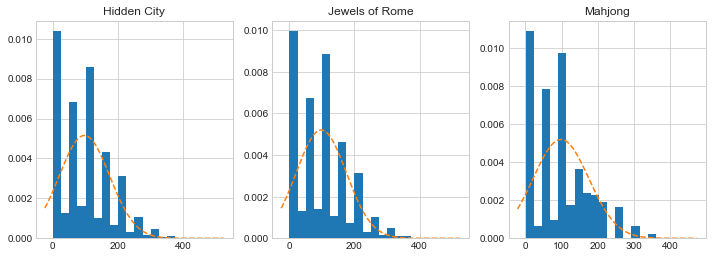

In [70]:
keys = list(total_payments.Game_ID.unique())

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(4 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(total_payments.loc[(total_payments['Game_ID'] == key) , 'Total_Payments'], density=True, bins=20)
    
    loc = total_payments.loc[(total_payments['Game_ID'] == key) , 'Total_Payments'].mean()
    scale = total_payments.loc[(total_payments['Game_ID'] == key) , 'Total_Payments'].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

In [71]:
# вероятно, допущение о том, что это когорта 4го дня, было слишком смелым

In [72]:
total_payments.loc[(total_payments['Game_ID'] == key) , 'Total_Payments']

20720    201.96
20721     11.98
20722     50.98
20723    102.96
20724      0.99
          ...  
31312     59.98
31313    112.95
31314    102.96
31315      1.99
31316      1.99
Name: Total_Payments, Length: 10597, dtype: float64

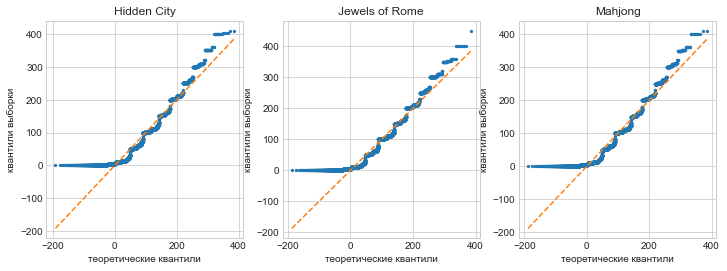

In [73]:
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(4 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    samples = total_payments.loc[(total_payments['Game_ID'] == key) , 'Total_Payments']
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

## Payments by game check

In [74]:
list(total_payments.Game_ID.unique())

['Hidden City', 'Jewels of Rome', 'Mahjong']

In [75]:
hc = np.array(total_payments.loc[(total_payments['Game_ID'] == 'Hidden City') , 'Total_Payments'])
jor = np.array(total_payments.loc[(total_payments['Game_ID'] == 'Jewels of Rome') , 'Total_Payments'])
mj = np.array(total_payments.loc[(total_payments['Game_ID'] == 'Mahjong') , 'Total_Payments'])

In [76]:
hc_len = len(hc)
jor_len = len(jor)
mj_len = len(mj)

hc_len, jor_len, mj_len

(10530, 10190, 10597)

In [77]:
hc_mean = hc.mean()
jor_mean = jor.mean()
mj_mean = mj.mean()

hc_mean, jor_mean, mj_mean

(97.19913675213675, 98.72315996074585, 98.22904123808625)

In [78]:
games = np.concatenate([hc, jor, mj])
games_mean = games.mean()
games_mean

98.04352460325063

In [79]:
SS_b = hc_len * (hc_mean - games_mean) ** 2 + jor_len * (jor_mean - games_mean) ** 2 + mj_len * (mj_mean - games_mean) ** 2

SS_w = ((hc - hc_mean) ** 2).sum() + ((jor - jor_mean) ** 2).sum() + ((mj - mj_mean) ** 2).sum()

SS_b, SS_w

(12579.308392973577, 185552705.8895613)

In [80]:
k = 3
n = len(games)

k1 = k - 1
k2 = n - k

sigma2_b = SS_b / k1
sigma2_w = SS_w / k2

sigma2_b, sigma2_w

(6289.654196486788, 5925.551059895296)

In [81]:
F = sigma2_b / sigma2_w
F

1.0614462913087996

In [82]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
t

2.99601888608252

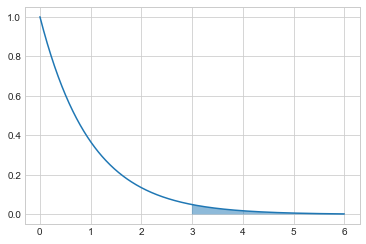

In [83]:
ox = np.linspace(0, 6, 500)
oy = stats.f.pdf(ox, k1, k2)

ox_right = np.linspace(t, 6, 100)
oy_right = stats.f.pdf(ox_right, k1, k2)

plt.plot(ox, oy)
plt.fill_between(ox_right, oy_right, alpha=0.5)

In [84]:
F > t

False

## Platform dependance check

In [85]:
list(total_payments.Platform.unique())

['Android', 'Facebook', 'iOS']

In [86]:
ios = np.array(total_payments.loc[(total_payments['Platform'] == 'iOS') , 'Total_Payments'])
gp = np.array(total_payments.loc[(total_payments['Platform'] == 'Android') , 'Total_Payments'])
fb = np.array(total_payments.loc[(total_payments['Platform'] == 'Facebook') , 'Total_Payments'])

In [87]:
ios_mean = ios.mean()
gp_mean = gp.mean()
fb_mean = fb.mean()

ios_mean, gp_mean, fb_mean

(97.69399913904437, 97.85492220049318, 98.83409142425387)

In [88]:
platforms = np.concatenate([ios, gp, fb])
platforms_mean = platforms.mean()
platforms_mean

98.04352460325065

In [89]:
SS_b = len(ios) * (ios_mean - platforms_mean) ** 2 + len(gp) * (gp_mean - platforms_mean) ** 2 + len(fb) * (fb_mean - platforms_mean) ** 2

SS_w = ((ios - ios_mean) ** 2).sum() + ((gp - gp_mean) ** 2).sum() + ((fb - fb_mean) ** 2).sum()

SS_b, SS_w

(6800.423290862025, 185558484.7746634)

In [90]:
k = 3
n = len(platforms)

k1 = k - 1
k2 = n - k

sigma2_b = SS_b / k1
sigma2_w = SS_w / k2

sigma2_b, sigma2_w

(3400.2116454310126, 5925.735606267593)

In [91]:
F = sigma2_b / sigma2_w
F

0.5738041437141815

In [92]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
t

2.99601888608252

In [93]:
F > t

False

## Total amount vs last payment time correlations

In [94]:
payments = np.array(total_time['Total_Payments'])
payments

array([150.97,  70.96, 119.97, ..., 102.96,   1.99,   1.99])

In [95]:
lasttime = np.array(total_time['LastTimeDiff'])
lasttime

array([4394., 4794., 3960., ..., 2598., 1642., 1991.])

In [96]:
np.corrcoef(payments, lasttime)[0][1]

0.21395165362839727

In [97]:
len(payments) == len(lasttime)

True

In [98]:
alpha = 0.05
n = len(payments)

In [99]:
def statistic(x: np.ndarray, y: np.ndarray) -> float:
    if len(x) == len(y):
        cov = ((x - x.mean()) * (y - y.mean())).sum() / (len(x) - 1)
        corr = cov / (x.std(ddof = 1) * y.std(ddof = 1))
        return (corr * (len(x) - 2) ** 0.5 / (1 - corr ** 2) ** 0.5)

In [100]:
def critical_borders (alpha, n):

    t1 = stats.t.ppf(alpha / 2, df = n - 2)
    t2 = stats.t.ppf(1 - alpha / 2, df = n - 2)

    return t1, t2

In [101]:
tl = statistic(payments, lasttime)
tl

38.75846160639498

In [102]:
tl1, tl2 = critical_borders(alpha, n)
tl1, tl2

(-1.9600397425271334, 1.960039742527133)

In [103]:
tl1 < tl < tl2

False

In [104]:
# False - корреляция значима

## First purchase amount vs first payment time correlations

In [105]:
first_payments = np.array(first_time['Payment_Amount'])
firsttime = np.array(first_time['FirstTimeDiff'])

In [106]:
np.corrcoef(first_payments, firsttime)[0][1]

-0.0036213603642896164

In [107]:
len(first_payments) == len(firsttime)

True

In [108]:
alpha = 0.05
n = len(first_payments)

In [109]:
tf = statistic(first_payments, firsttime)
tf

-0.6408417529277728

In [110]:
tf1, tf2 = critical_borders(alpha, n)
tf1, tf2

(-1.9600397425271334, 1.960039742527133)

In [111]:
tf1 < tf < tf2

True

In [112]:
# True - корреляции нет